### PID control of `Snapbot`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mujoco_parser import MuJoCoParserClass
from pid import PID_ControllerClass
from snapbot_util import get_snapbot_q
np.set_printoptions(precision=2)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("Done.")

Done.


### PID control

Creating window glfw
Creating offscreen glfw


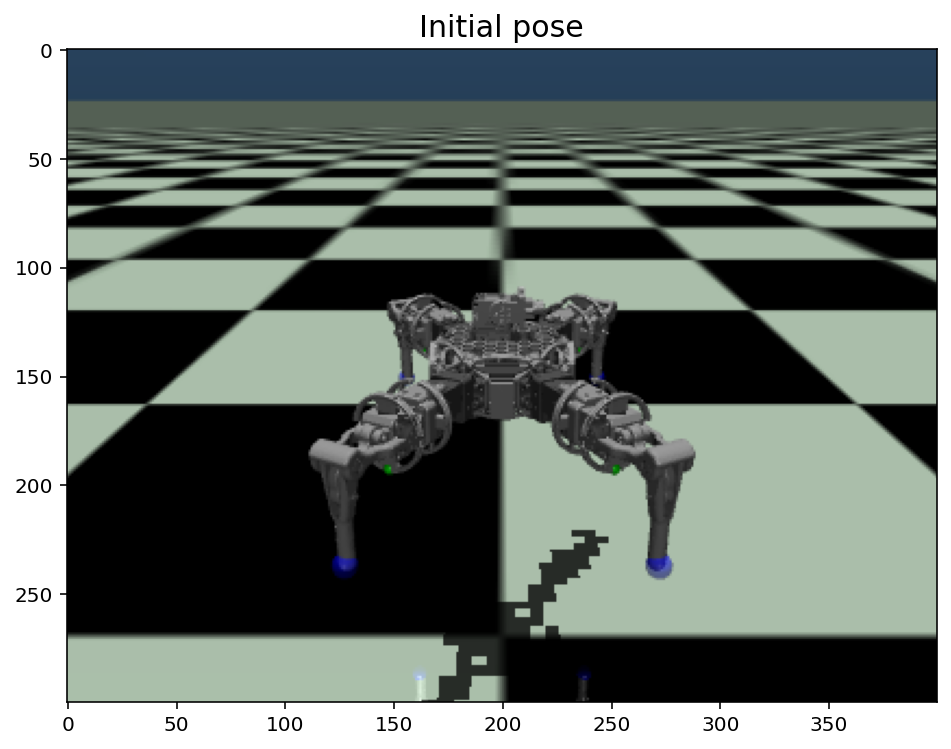

In [2]:
env = MuJoCoParserClass(name='Snapbot',rel_xml_path='../asset/snapbot/robot_4_1245.xml',VERBOSE=False)
env.init_viewer(TERMINATE_GLFW=False,INITIALIZE_GLFW=True,window_width=0.5,window_height=0.5,
                cam_elevation=-20,cam_distance=0.75)
env.set_max_sec(max_sec=5.0)
PID = PID_ControllerClass(
    name = 'PID',dim = env.n_actuator,
    k_p = 20.0, k_i = 0.1, k_d = 1.0,
    out_min = env.torque_range[:,0],
    out_max = env.torque_range[:,1],
    ANTIWU  = True)
env.plot_scene(figsize=(10,6),render_w=400,render_h=300,
               cam_distance=0.75,cam_elevation=-20,cam_lookat=env.get_p_body(body_name='torso'),
               title_str='Initial pose',title_fs=15,RETURN_IMG=False)

tick:[1/1250], sec_wall:[0.336]sec, sec_sim:[0.004]sec
tick:[250/1250], sec_wall:[0.885]sec, sec_sim:[1.000]sec
tick:[500/1250], sec_wall:[1.862]sec, sec_sim:[2.000]sec
tick:[750/1250], sec_wall:[2.865]sec, sec_sim:[3.000]sec
tick:[1000/1250], sec_wall:[3.901]sec, sec_sim:[4.000]sec
tick:[1250/1250], sec_wall:[4.950]sec, sec_sim:[5.000]sec


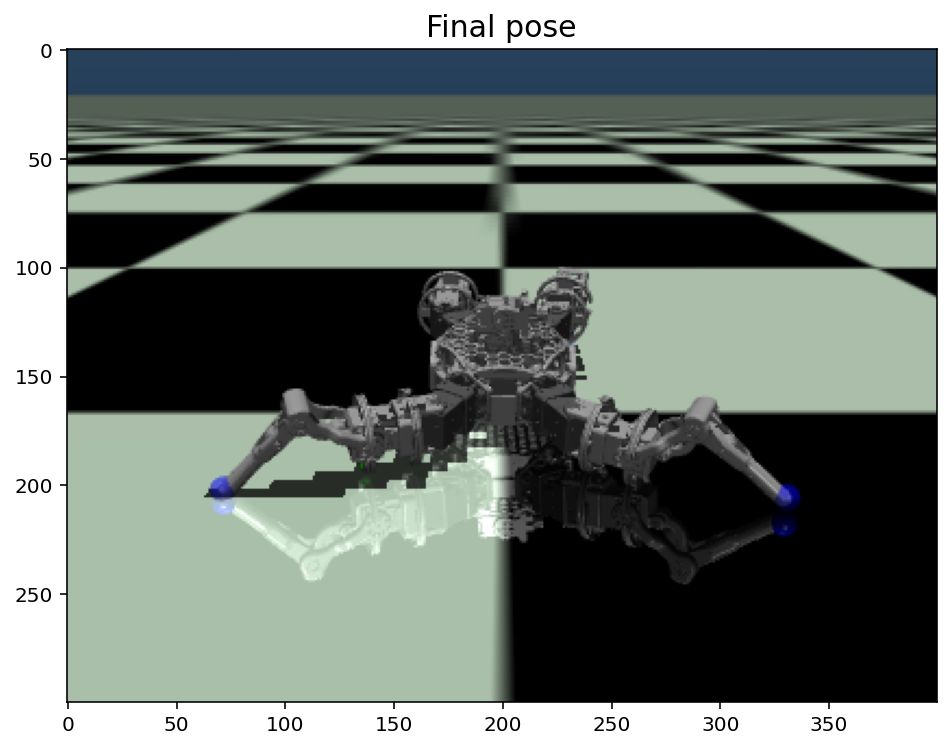

Done.


In [3]:
# x_trgt = np.zeros(env.n_torque)
x_trgt      = 45*np.pi/180.0*(-1.0+2.0*np.random.rand(env.n_actuator))
t_list      = np.zeros(shape=(env.max_tick))
x_trgt_list = np.zeros(shape=(env.max_tick,env.n_actuator))
q_list      = np.zeros(shape=(env.max_tick,env.n_actuator))
torque_list = np.zeros(shape=(env.max_tick,env.n_actuator))
PID.reset()
env.reset()
while env.IS_ALIVE():
    # PD controller
    q = get_snapbot_q(env) # current joint position
    PID.update(x_trgt=x_trgt,t_curr=env.get_sec_sim(),x_curr=q,VERBOSE=False)
    # Step
    torque = PID.out()
    env.step(ctrl=torque,ctrl_idxs=None)
    env.render(render_speedup=1.0,cam_lookat=env.get_p_body(body_name='torso'),RENDER_ALWAYS=False)
    env.print(print_every_sec=1,VERBOSE=1)
    # Append
    t_list[env.tick-1]        = env.get_sec_sim()
    x_trgt_list[env.tick-1,:] = PID.x_trgt
    q_list[env.tick-1,:]      = q
    torque_list[env.tick-1,:] = torque
# Plot final scene
env.plot_scene(figsize=(10,6),render_w=400,render_h=300,
               cam_distance=0.75,cam_elevation=-20,cam_lookat=env.get_p_body(body_name='torso'),
               title_str='Final pose',title_fs=15,RETURN_IMG=False)
env.terminate_viewer()
env.sleep(1.0)
print ("Done.")

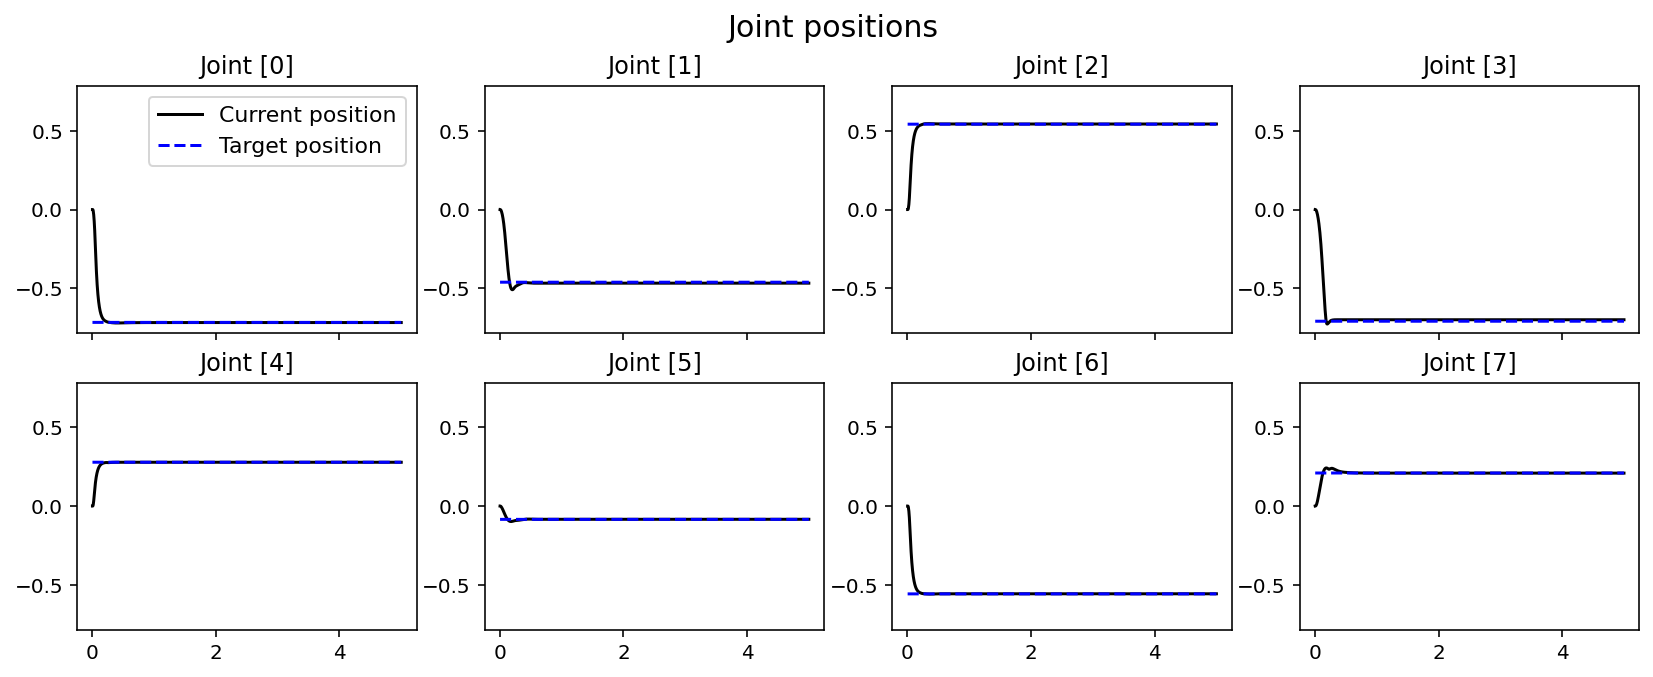

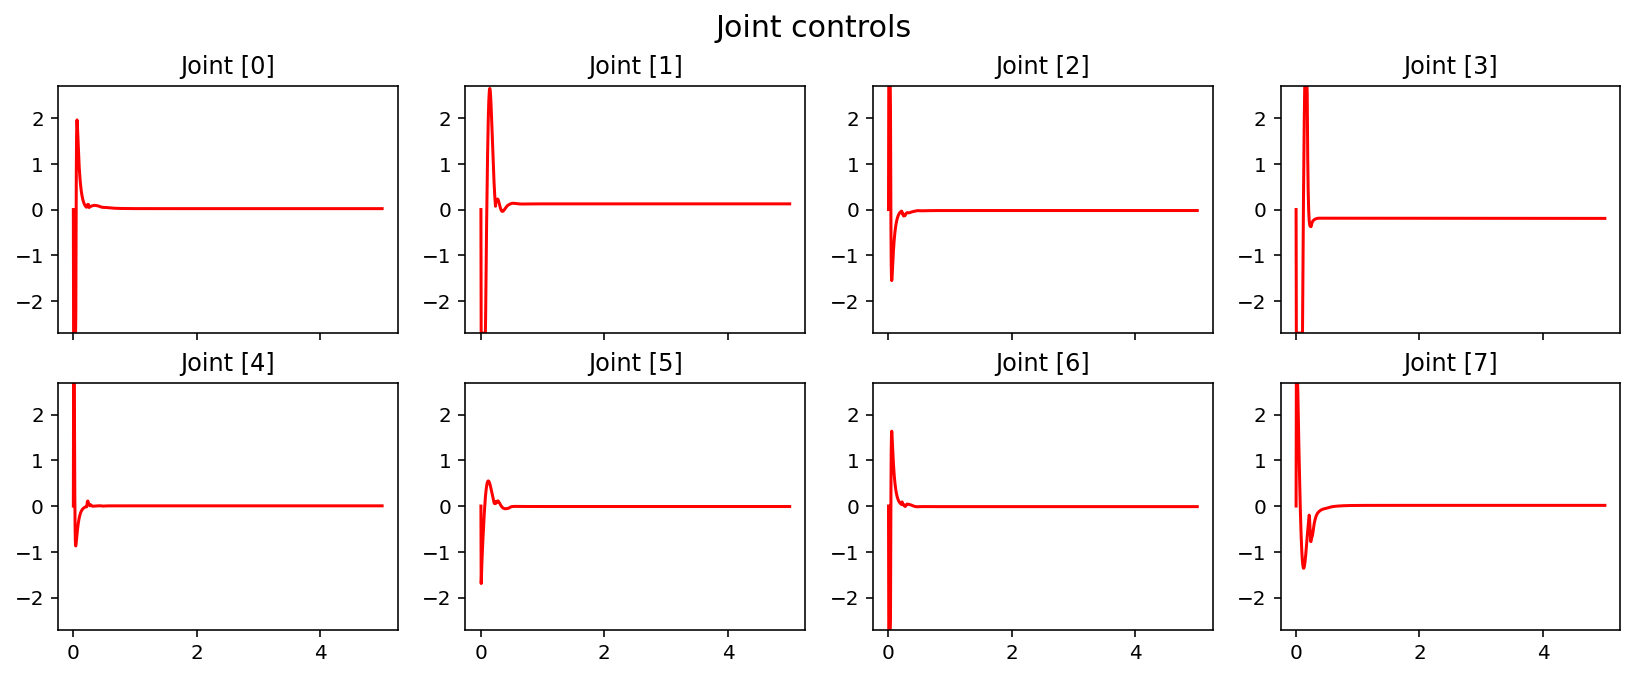

In [4]:
# Plot target and current joint position
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,5))
fig.suptitle("Joint positions", fontsize=15)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list,q_list[:,a_idx],color='k',label='Current position')
    ax.plot(t_list,x_trgt_list[:,a_idx],'--',color='b',label='Target position')
    ax.set_ylim(bottom=-45*np.pi/180.0,top=45*np.pi/180.0)
    ax.set_title('Joint [%d]'%(a_idx))
    if a_idx == 0:
        ax.legend(fontsize=11)
plt.show()
# Plot control output
fig,axs = plt.subplots(nrows=2,ncols=4,sharex=True,sharey=False,figsize=(14,5))
fig.suptitle("Joint controls", fontsize=15)
for a_idx,ax in enumerate(axs.ravel()):
    ax.plot(t_list,torque_list[:,a_idx],color='r')
    ax.set_ylim(bottom=env.torque_range[a_idx,0],top=env.torque_range[a_idx,1])
    ax.set_title('Joint [%d]'%(a_idx))
plt.show()